# Bayesian Evidence

For any Bayesian model, we have the following representation due to the bayes formulae:

$$
p(\theta|d, M) = \frac{L(d|\theta,M) \pi(\theta|M)}{Z(d|M)}
$$

Where $ Z(d|M) = \int_{\theta}L(d|\theta,M) \pi(\theta|M) d\theta $, is the evidence of the data over the Model (also known as the marginal likelihood). Bayesian evidence is a very important quantity in bayesian analysis, as it allows us to compare the validity of the data being generated by two model by the Bayes factor.

$$
BF = \frac{p(d|M_1)}{p(d|M_2)} = \frac{Z(d|M_1)}{Z(d|M_2)}
$$

Thus calculating the evidence is important for bayesian analysis, as it is useful for model selection.

Evaluating marginal likelihood with MCMC is non-trivial. Marginal likelihood is an multi-dimensional integral over the whole parameter space, but it is usually very heavily dominated by a very small part of the space and hence sampling from the prior to evaluate it results in very high variance of the results. (Why high variance?) An added difficulty is that the likelihood is often sharply peaked within the prior range, but possibly with long tails that do contribute significantly to the integral and which cannot be neglected. 

It is possible to construct an importance sampling estimator to the marginal likelihood as the so called harmonic mean estimator, but this is extremely unreliable in practice and should never be used.

Will see in examples for log(Z)
Using mcmc sampling, numerically, importance sampling, laplace approximation, thermodynamic integral

## Laplace Approximation

Laplace approximation is a common method where we approximate the posterior distribution using the guassian distribution.

$ Z(d|M) = \int_{\theta}L(d|\theta,M) \pi(\theta|M) d\theta = \int_{\theta} f(\theta) d \theta $, and we approximate the function $f(\theta)$ with a multivariate gaussian fitted at the maximum (mode $\hat{\theta}$) of the distribution.

By the secound order Approximation of the taylor series, we can get the covaraince of the fitted gaussian as the Hessian of function $f(\theta)$ at $\hat{\theta}$.

### Single Dimension

using X in place of theta:

Let $P = f(x|M)$, and $L = ln(P)$, the logarithm of function P, then by taylor expansion

$$
L = ln(P) = L(x_0) + \frac{dL}{dx}(x-x_0) + \frac{1}{2} \frac{d^2L}{dx^2}(x-x_0)^2
$$

as $\frac{dL}{dx} = 0$ at $x_0$, we get 

$$
P = A exp[-\frac{(x-x_0)^2}{2\sigma^2} ] = exp(L(x_0))*exp\Bigl[\frac{1}{2} \frac{d^2L}{dx^2}(x-x_0)^2\Bigr]
$$

Hense $A = exp(L(x_0))$, $\sigma = (-\frac{d^2L}{dx^2})^{-1}$, and the integral 

$$
\int_{-\infty}^{+\infty} f(\theta) d\theta = \int_{-\infty}^{+\infty} A exp[-\frac{(x-x_0)^2}{2\sigma^2} ] dx = A (\sigma\sqrt{2\pi}) 
$$

Laplace approximation also has a number of important limitations. Obviously it is only suited for unimodal distributions. It is sensitive to the parametrisation of $\theta$, Furthermore, if the posterior is skewed in a way that leaves the mode far from the bulk of the posterior mass, Laplace approximation is constrained.

### Multiple Dimensions
Let $P = f(\textbf{x}|M)$, with $\textbf{x}$, as a multidimensional vector, we can express L using taylor expansion as:

$$
L = L(\textbf{x}_o) + 0 + \frac{1}{2} \sum_{i = 1}^{M} \sum_{j = 1}^{M} \frac{\partial^2 L}{\partial x_i \partial x_j} (x_i-x_{oi})(x_j - x_{oj}) 
$$

this gets us:

$$
P = A exp[\frac{1}{2} (\textbf{x} - \textbf{x}_0)^T \nabla \nabla L(\textbf{x}_0) (\textbf{x} - \textbf{x}_0)^T ]
$$

Where $A = exp(L(x_0)) \; $, and $ \; \nabla \nabla L(\textbf{x}_0)_{i,j} = \mathbf{\Sigma}^{-1}_{i,j} = -\frac{\partial^2 L}{\partial x_i \partial x_j} = $ Hessian of the target logfunction at the maxima (mode) point.

This gives us the integral as:-

$$
\int_{} \int_{} .. \int_{} f(\mathbf{\theta}|M) d\theta = A*\sqrt{\frac{(2\pi)^M}{det \mathbf{\Sigma}}}
$$


## Laplace Example

We will use the standard example of Bayesian inference on the mean of a Normal distribution given the variance.

```{admonition} Note
 We have changed the problem of inference to a problem of Optimisation
```

In [6]:
# Creating data for 1.0 mean 1.0 std normal distribution, and using laplace approximation to calculate evidence
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt

def log_comp_likelihoodf(x, mu, sigma):
    return jnp.sum(-0.5 * jnp.log(2 * jnp.pi * sigma**2) - 0.5 * (x - mu)**2 / sigma**2)

# Simulating 100 data points from a normal distribution with mean 1.0 and std 1.0
n = 100
mu = 1.0 ; sigma = 1.0
data = random.normal(random.PRNGKey(6), shape=(n,)) + mu

# Setting the prior
prior_mu = 0.0 ; prior_sigma = 3.0
log_likelihoodf = lambda mu: log_comp_likelihoodf(data, mu, sigma)
log_priorf = lambda mu: -0.5 * jnp.log(2 * jnp.pi * prior_sigma**2) - 0.5 * (mu - prior_mu)**2 / prior_sigma**2

@jax.jit
def log_target(mu):
    return -(log_likelihoodf(mu) + log_priorf(mu))

# Jax.vmap is very useful, as it removes the indexing issues
derivative_log_target = jax.vmap(jax.grad(log_target))
hessian_log_target = jax.hessian(log_target)

# Finding the mode of the posterior
theta_opt = opt.minimize(log_target, x0= jnp.ones(1), jac=derivative_log_target, method='Newton-CG')

print('posterior mode:', theta_opt.x[0])

x0 = theta_opt.x[0]
 
# Note: taking the absolute value of Hessian to avoid worrying about signs
logZ = -log_target(x0) + 0.5*np.log(2*np.pi) - 0.5*np.log(np.abs(hessian_log_target(x0)))
print("logZ =", logZ)

posterior mode: 1.049509
logZ = -139.04999


## Thermodynamic Integration
Thermodynamic integral also known as simulated annealing, is similar to parallel Tempering in the fact that, we use multiple chains at different temperature to get the $\beta = 1$ chains integral.

First we define the probabilities of thermal chains again:

$$
\pi^{*} (\theta) = p(D|\theta)p(\theta), \; \; \pi^{*}_{\beta} (\theta) = p(D|\theta)^{\beta}p(\theta), \; \; \pi_{\beta} (\theta) = \frac{\pi^{*}_{\beta} (\theta)}{Z_{\beta}}
$$

Also the values of Z's

$$
Z_{\beta} = \int_{\theta} \pi_{\beta} (\theta) d(\theta) = \int_{\theta} p(D|\theta)^{\beta}p(\theta) d(\theta) \\
Z_{1} = p(D|M) = \int_{\theta} \pi^{*} (\theta) d(\theta) \\
Z_{0} = \int_{\theta} p(\theta) d(\theta)  = 1 \\
$$

Using these, we can prove that: 

$$
ln(p(D|M)) = ln(Z_1) - ln(Z_0) = \int_{0}^{1} \frac{\partial ln(Z_{\beta})}{\partial \beta} d \beta = \int_{0}^{1} \mathbb{E} [ ln(p(D|\theta)) ] d \beta
$$

The integral can be seen as an expectation over  $\pi_{\beta}(\theta)$ and using samples from the thermodynamic MCMC chains, we can find the value of $\mathbb{E} [ ln(p(D|\theta)) ]$ (This can be got for any beta by collecting samples for that beta and transforming them using log_likelihood, and getting the mean ).

Note, the expectation calculation is a multivariate integral so a major source of variance of the calculation but the final integral is one dimensional so, easy to calculate.

## Thermodynamic Expectation Example
We will be doing the same example of Bayesian inference on the mean of a Normal distribution given the variance.


In [5]:
import scipy.integrate  # To get the final integral 
import numpy.random as npr

def log_comp_likelihoodf(x, mu, sigma):
    return np.sum(-0.5*np.log(2*np.pi) - np.log(sigma) - 0.5 * (x-mu)**2/sigma**2)

# Simulating 100 data points from a normal distribution with mean 1.0 and std 1.0
n = 100
mu = 1.0 ; sigma = 1.0
data = random.normal(random.PRNGKey(6), shape=(n,)) + mu

# Setting the prior
prior_mu = 0.0 ; prior_sigma = 3.0
log_likelihoodf = lambda mu: log_comp_likelihoodf(data, mu, sigma)
log_priorf = lambda mu: -0.5 * jnp.log(2 * jnp.pi * prior_sigma**2) - 0.5 * (mu - prior_mu)**2 / prior_sigma**2

# Will do the integral for 20 values of beta, over 10000 iterations
CHAINS = 20
ITERS = 10000
betas = np.concatenate((np.array([0.0]), np.logspace(-5, 0, CHAINS)))

# Array for storing the values
xx = np.zeros((ITERS, CHAINS+1))
accept_rate = np.zeros(CHAINS+1)

# Metropolis sampler
def log_MHsample(theta0, n, logtarget, drawproposal):
    theta = theta0
    thetas = np.zeros(n)
    accepts = 0
    for i in range(n):
        theta_prop = drawproposal(theta)
        if np.log(npr.rand()) < logtarget(theta_prop) - logtarget(theta):
            theta = theta_prop
            accepts += 1
        thetas[i] = theta
    return thetas, accepts/n

# Using the Metropolis sampler to get the samples, proposal gets smaller with beta

for i in range(CHAINS+1):
    xx[:,i], accept_rate[i] = log_MHsample(np.zeros(1), ITERS, 
                                    logtarget = lambda x: betas[i]*log_likelihoodf(x)+log_priorf(x),
                                    drawproposal = lambda x: x + 0.2/np.sqrt(betas[i]+1e-3)*npr.normal(size=1))

This calculation took around 2.5 minutes (2 min sampline, 30s integral) in my computer, compared to the laplace integral which took only 0.2s. This shows that we have to choose which method to use based on our **need**: more speed?, more accuaracy ? High-dimensions?

As we can see in this single dimensional problem, we got a nice and quite accurate value of the **Evidence** using both methods, but keep in mind that they will be increasingly less useful in higher dimensional or tricky prior scenarios.

logZ_trapezoidal = -139.22641924584678
Marginal likelihood: -138.99704316390387


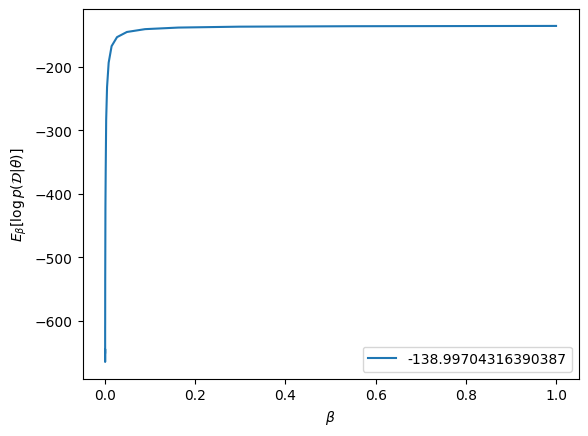

In [10]:
samples = np.zeros(xx.shape)
for i in range(samples.shape[0]):
    for j in range(samples.shape[1]):
        # We calculate the prob of sample for the given data
        samples[i,j] = log_likelihoodf(xx[i,j])

log_likelihoods = np.mean(samples, 0)

# Using the trapezoidal rule to get the integral
logZ_trap = np.trapz(log_likelihoods, betas)
print("logZ_trapezoidal =", logZ_trap)

# Using the Simpson's rule to get the integral
print('Marginal likelihood:',scipy.integrate.simps(log_likelihoods, betas))

# Plotting the log likelihoods
plt.plot(betas, log_likelihoods, label = scipy.integrate.simps(log_likelihoods, betas)); plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$E_\beta[ \log p(\mathcal{D} | \theta)]$')
plt.show()

In [ ]:
# A full Jax implimentation of the above code

### Proof of Thermodynamic expectation

We have to prove:

$$
ln(p(D|M)) = ln(Z_1) - ln(Z_0) = \int_{0}^{1} \frac{\partial ln(Z_{\beta})}{\partial \beta} d \beta = \int_{0}^{1} \mathbb{E} [ ln(p(D|\theta)) ] d \beta
$$

The integrand can be expressed as:

\begin{align}
\frac{\partial ln(Z_{\beta})}{\partial \beta}  &=  \frac{1}{Z_{\beta}} \frac{\partial Z_{\beta}}{\partial \beta}  \\
& =  \frac{1}{Z_{\beta}} \frac{\partial}{\partial \beta} \int_{\theta} \pi^{*}_{\beta}(\theta) d \theta \\
& =  \frac{1}{Z_{\beta}} \int_{\theta} \frac{\partial  \pi^{*}_{\beta}(\theta)}{\partial \beta} d \theta \\
& = \int_{\theta} \frac{1}{\pi^{*}_{\beta}(\theta)} \frac{\partial \pi^{*}_{\beta}(\theta)}{\partial \beta} \frac{\pi^{*}_{\beta}(\theta)}{Z_{\beta}} d \theta \\
& = \int_{\theta} \frac{\partial ln(\pi^{*}_{\beta}(\theta))}{\partial \beta} \pi^{*}_{\beta}(\theta) d \theta

\end{align}

Also we have:

$$
ln(\pi^{*}_{\beta}(\theta)) = \beta ln p (D|\theta) + ln(p(\theta)) \implies \frac{\partial ln(\pi^{*}_{\beta}(\theta))}{\partial \beta} = ln(p (D|\theta))
$$

Hense:
\begin{align}
\frac{\partial ln(Z_{\beta})}{\partial \beta}  &=  \int_{\theta} ln(p (D|\theta)) \pi^{*}_{\beta}(\theta) d \theta \\
& = \mathbb{E}_{\beta} [ln p (D|\theta)] d \beta
\end{align}

Hense:

$$
ln(p(D|M)) = ln(Z_1) - ln(Z_0) = \int_{0}^{1} \frac{\partial ln(Z_{\beta})}{\partial \beta} d \beta = \int_{0}^{1} \mathbb{E} [ ln(p(D|\theta)) ] d \beta
$$


**Why does it work so well?**

Why does it work so much better than ordinary importance sampling (Try out)

## Nested Sampling
Nested Sampling and MultiModal Nested Sampling in brief.